In [19]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline

In [20]:
# Path settings
import os
# we use a relative path here, you can also specify an absolute path for your system
out_path = "output/05_hyperelasticity_neohook_testing"
os.makedirs(out_path, exist_ok=True)

import fenics as fe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt 

fe.parameters["form_compiler"]["representation"] = "uflacs"
#fe.parameters["form_compiler"]["quadrature_degree"] = "2"

In [21]:
def get_tensor_components(tensor, point, name=None):
    index_2d = {   'xx' : 0, 'xy' : 1,
                   'yx' : 2, 'yy' : 3}
    index_3d = {   'xx' : 0, 'xy' : 1, 'xz' : 2,
                   'yx' : 3, 'yy' : 4, 'yz' : 5,
                   'zx' : 6, 'zy' : 7, 'zz' : 8}
    tensor_at_point = tensor(point)
    if len(tensor_at_point)==4:
        name_val_dict = { key : tensor_at_point[index] for key, index in index_2d.items()}
    elif len(tensor_at_point)==9:
        name_val_dict = { key : tensor_at_point[index] for key, index in index_3d.items()}
    else:
        print("Tensor at has %i elements -- can't handle"%len(tensor_at_point))
        name_val_dict = {}
    if name:
        name_val_dict = { "%s_%s"%(name, key) : val for key, val in name_val_dict.items()}
    return name_val_dict
        

In [22]:
# mesh

length_x = 1.0
length_y = 1.0
length_z = 1.0
#mesh = fe.RectangleMesh(fe.Point(0,0), fe.Point(length_x,length_y), 100,100)
mesh = fe.BoxMesh(fe.Point(0,0,0),fe.Point(length_x, length_y, length_z),1,1,1)

# FunctionSpace
V = fe.VectorFunctionSpace(mesh, "Lagrange", 1)

# Finite element functions
du = fe.TrialFunction(V)
v  = fe.TestFunction(V)
u  = fe.Function(V)
u.rename("displacement[mm]", "")

In [23]:
# Mark edges
edges_y  = fe.CompiledSubDomain("(near(x[0], side_x_1) || near(x[0], side_x_2) ) && ( near(x[2], side_z_1) || near(x[2], side_z_2) ) && on_boundary", side_x_1 = 0, side_x_2 = 1, side_z_1=0, side_z_2=1)
edges_z  = fe.CompiledSubDomain("(near(x[0], side_x_1) || near(x[0], side_x_2) ) && ( near(x[1], side_y_1) || near(x[1], side_y_2) ) && on_boundary", side_x_1 = 0, side_x_2 = 1, side_y_1=0, side_y_2=1)

edges = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 2)
edges.set_all(0)
edges_y.mark(edges, 1)
edges_z.mark(edges, 2)

#-- save boundary to vtu for inspection
boundary_file = fe.File(os.path.join(out_path, "edges.pvd"))
boundary_file << edges

In [24]:
# Mark boundary subdomians
left =  fe.CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
# Define Dirichlet BC: zero displacement on left side (x = 0)
#bc_left_expr = fe.Expression(("0.0", "0.0", "0.0"), element=V.ufl_element())
#bcl = fe.DirichletBC(V, bc_left_expr, left)
bcl = fe.DirichletBC(V.sub(0), 0, left)


# Mark boundary subdomians
right =  fe.CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)
# Define Dirichlet BC: zero displacement on left side (x = 0)
#bc_right_expr = fe.Expression(("d", "0.0", "0.0"), d=0.0, element=V.ufl_element())
bc_right_expr = fe.Expression(("d"), d=0.0, element=V.sub(0).ufl_element())
#bcr = fe.DirichletBC(V, bc_right_expr, right)
#d=0
bcr = fe.DirichletBC(V.sub(0), bc_right_expr, right)

# Dirichlet egdes
bc_egdes_y = fe.DirichletBC(V.sub(1), 0, edges_y, method="pointwise")
bc_egdes_z = fe.DirichletBC(V.sub(2), 0, edges_z, method="pointwise")

bcs = [bcl, bcr, bc_egdes_y, bc_egdes_z]

In [25]:
# Functions for 

def defGrad(u):
    """
    Compute deformation gradient from displacements
    """
    d = u.geometric_dimension()
    I = fe.Identity(d)
    F = I + fe.grad(u)             
    return F


def strainEnergyDensityFunctionNeoHookean(F, mu, lmbda):
    C = F.T*F      # Right Cauchy-Green tensor
    I1 = fe.tr(C)  # Invariants 
    J = fe.det(F)
    #return (mu/2)*(I1 - 3)- mu*fe.ln(J) + (lmbda/2)*(fe.ln(J))**2
    return (mu/2.)*(I1 - 3.) - mu*fe.ln(J) + (lmbda/2.)*(J-1.)**2.

In [26]:
Ey = 1000E-6
nu= 0.45

mu    = Ey / (2.*(1+nu))
lmbda = Ey*nu / ((1+nu)*(1-2*nu))
print(mu, lmbda)

0.0003448275862068966 0.00310344827586207


In [27]:
# create deformation gradient
F = defGrad(u)

F = fe.variable(F) # !!! needed to be able to differentiate strain energydensity function wrt F for stress computation

# instantiate strain energy density function for given material properties

psi = strainEnergyDensityFunctionNeoHookean(F=F, mu=mu, lmbda=lmbda)

# total potential energy 
Pi = psi * fe.dx 

# Compute 1st variation of Pi (directional derivative about u in dir. of v)
Fpi = fe.derivative(Pi, u, v)

# Compute Jacobian of F
Jac = fe.derivative(Fpi, u, du)

In [28]:
# Define the solver
problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac)
solver = fe.NonlinearVariationalSolver(problem)

# Set solver parameters (optional)
prm = solver.parameters
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'mumps'
# prm['newton_solver']['linear_solver'] = 'cg'
# prm['newton_solver']['preconditioner'] = 'icc'

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [29]:
T = fe.TensorFunctionSpace(mesh, 'P', 1)
W = fe.FunctionSpace(mesh, 'P', 1)

# Create XMDF file for the solution
xmdffile = fe.XDMFFile(os.path.join(out_path, 'results.xdmf'))
xmdffile.parameters["flush_output"] = True
xmdffile.parameters["functions_share_mesh"] = True

df = pd.DataFrame()

for d in np.arange(-0.5, 2, 0.2):
    stretch = (length_x + d)/length_x
    print("-- solving for stretch = %.2f"%stretch)
    bc_right_expr.d = d
    solver.solve()
    # compute stresS
    S = 1/fe.det(F)*fe.diff(psi, F)*F.T            
    #S = fe.diff(psi, F)  
    S_project = fe.project(S, T, solver_type='cg')
    S_project.rename("cauchy_stress[MPa]", "")
    xmdffile.write(S_project,d)
    # output
    xmdffile.write(u,d)
    u_project = fe.project(u, V, solver_type='cg')
    # project F
    F_project = fe.project(F, T, solver_type='cg')
    F_project.rename("deformation_gradient", "")
    xmdffile.write(F_project,d)
    # project C
    C_project = fe.project(F.T*F, T, solver_type='cg')
    C_project.rename("cauchy_green", "")
    xmdffile.write(C_project,d)
    # compute J
    J = fe.det(F)
    J_project = fe.project(J, W, solver_type='cg')
    J_project.rename("det(F)", "")
    xmdffile.write(J_project,d)
    
    # to table
    point = fe.Point(1, 0.5)
    s = S_project(point)
    f = F_project(point)
    c = C_project(point)
    j = J_project(point)
    U = u_project(point)
    df_dict = {}
    df_dict["stretch_ratio"] = stretch
    df_dict.update( get_tensor_components(S_project, point, 'S') )
    df_dict.update( get_tensor_components(F_project, point, 'F') )
    df_dict.update( get_tensor_components(C_project, point, 'C') )
    df_dict["Sxx_analytic"] = mu/np.power(j, 5./3.) * (stretch*stretch - j/stretch) # 3D, uniaxial tension, unconstrained; https://en.wikipedia.org/wiki/Neo-Hookean_solid
    df_dict["Syy_analytic"] = 0.0
    df_dict["Szz_analytic"] = df_dict["Syy_analytic"]
    df_dict["u_x"] = U[0]
    df = df.append(df_dict, ignore_index=True)


xmdffile.close()    
    

-- solving for stretch = 0.50
Calling FFC just-in-time (JIT) compiler, this may take some time.
-- solving for stretch = 0.70
-- solving for stretch = 0.90
-- solving for stretch = 1.10
-- solving for stretch = 1.30
-- solving for stretch = 1.50
-- solving for stretch = 1.70
-- solving for stretch = 1.90
-- solving for stretch = 2.10
-- solving for stretch = 2.30
-- solving for stretch = 2.50
-- solving for stretch = 2.70
-- solving for stretch = 2.90


In [30]:
print(j)
J_project.vector().get_local()

1.0659249720062043


array([1.06592497, 1.06592497, 1.06592497, 1.06592497, 1.06592497,
       1.06592497, 1.06592497, 1.06592497])

In [31]:
df["S_xx_norm"] = df["S_xx"]/mu
df["S_xy_norm"] = df["S_xy"]/mu
df["S_yx_norm"] = df["S_yx"]/mu
df["S_yy_norm"] = df["S_yy"]/mu
df["S_zz_norm"] = df["S_zz"]/mu
df["Sxx_analytic_norm"] = df["Sxx_analytic"]/mu
df["Syy_analytic_norm"] = df["Syy_analytic"]/mu
df["Szz_analytic_norm"] = df["Szz_analytic"]/mu
df["1/stretch_ratio"] = 1./df["stretch_ratio"]
df["stretch_ratio_quad"] = np.power(df["stretch_ratio"],2)
df["1/stretch_ratio_quad"] = np.power(df["1/stretch_ratio"],2)
df["S_xx_rel_error"] = (df["Sxx_analytic_norm"]-df["S_xx_norm"])/df["Sxx_analytic_norm"]
df.loc[np.isclose(df.stretch_ratio,1.0),"S_xx_rel_error"]=np.nan
df[["S_xx_norm", "Sxx_analytic_norm", "S_xx_rel_error", "stretch_ratio", "u_x"]]

,S_xx_norm,Sxx_analytic_norm,S_xx_rel_error,stretch_ratio,u_x
0,-1.722556,-1.846416,0.067081,0.5,-0.500000
1,-0.916733,-0.943773,0.028651,0.7,-0.300000
2,-0.292020,-0.294201,0.007413,0.9,-0.100000
3,0.290000,0.288252,-0.006062,1.1,0.100000
4,0.882565,0.869213,-0.015361,1.3,0.300000
5,1.510525,1.477760,-0.022172,1.5,0.500000
6,2.187033,2.128761,-0.027374,1.7,0.700000
7,2.919707,2.830609,-0.031477,1.9,0.900000
8,3.713259,3.588400,-0.034795,2.1,1.100000
9,4.570766,4.405409,-0.037535,2.3,1.300000


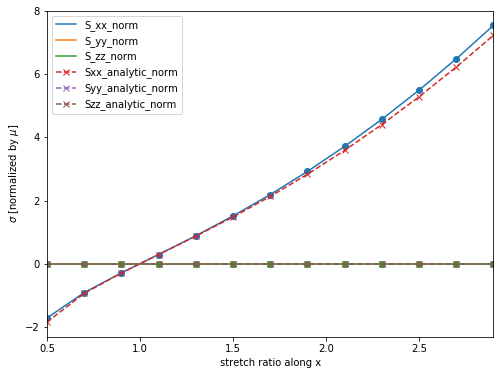

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
df.plot(x="stretch_ratio", y=["S_xx_norm", "S_yy_norm", "S_zz_norm"], marker='o', ax=ax)
df.plot(x="stretch_ratio", y=["Sxx_analytic_norm", "Syy_analytic_norm", "Szz_analytic_norm"], marker='x', linestyle='--', ax=ax)
#df.plot(x="stretch_ratio", y=["S_xx_norm_ana<lytic"], marker='x', ax=ax)
#df.plot(x="stretch_ratio", y=["1/stretch_ratio"], marker='s', ax=ax)
ax.set_ylabel("$\sigma$ [normalized by $\mu$]")
ax.set_xlabel("stretch ratio along x")
plt.show()


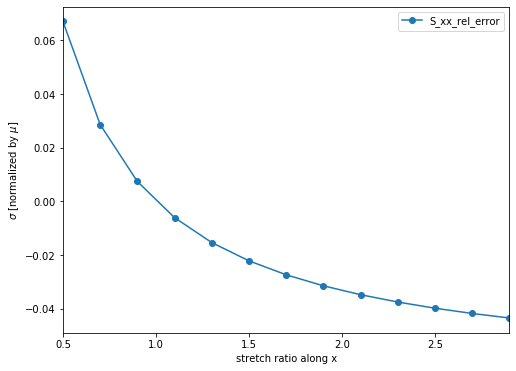

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
df.plot(x="stretch_ratio", y=["S_xx_rel_error"], marker='o', ax=ax)
    
ax.set_ylabel("$\sigma$ error [normalized by $\mu$]")
ax.set_xlabel("stretch ratio along x")
plt.show()


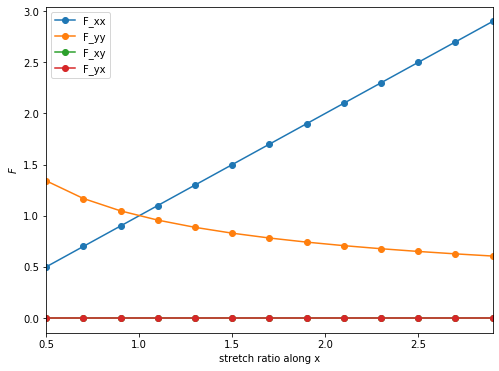

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
df.plot(x="stretch_ratio", y=["F_xx", "F_yy", "F_xy", "F_yx"], marker='o', ax=ax)
    
ax.set_ylabel("$F$")
ax.set_xlabel("stretch ratio along x")
plt.show()


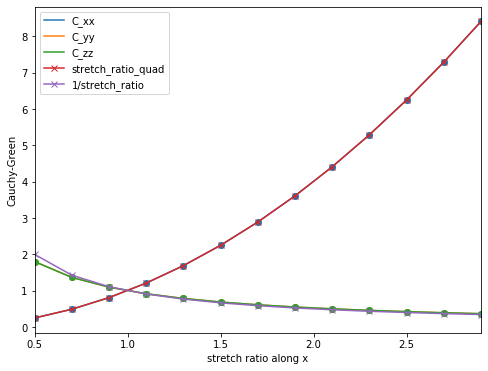

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
df.plot(x="stretch_ratio", y=["C_xx", "C_yy", "C_zz"], marker='o', ax=ax)
df.plot(x="stretch_ratio", y=["stretch_ratio_quad", "1/stretch_ratio"], marker='x', ax=ax)
    
    
ax.set_ylabel("Cauchy-Green")
ax.set_xlabel("stretch ratio along x")
plt.show()
